In [1]:
from non_local_detector.simulate.sorted_spikes_simulation import make_simulated_data

(
    speed,
    position,
    spike_times,
    time,
    event_times,
    sampling_frequency,
    is_event,
    place_fields,
) = make_simulated_data()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/edeno/Documents/GitHub/non_local_detector/src/non_local_detector/likelihoods/clusterless_kde.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from non_local_detector import NonLocalSortedSpikesDetector
import numpy as np

detector = NonLocalSortedSpikesDetector()

position = position[:, np.newaxis] if position.ndim == 1 else position
detector.fit(
    time,
    position,
    spike_times,
    is_training=~is_event
)

Encoding models:   0%|          | 0/25 [00:00<?, ?cell/s]

NonLocalSortedSpikesDetector(continuous_initial_conditions_types=[UniformInitialConditions(),
                                                                  UniformInitialConditions(),
                                                                  UniformInitialConditions(),
                                                                  UniformInitialConditions()],
                             continuous_transition_types=[[<non_local_detector.continuous_state_transitions.Discrete object at 0x16242b790>,
                                                           <non_local_detector.continuous_state_transitions.Discrete object at 0x...
                                                                  encoding_group=0,
                                                                  is_local=False,
                                                                  is_no_spike=False),
                                                 ObservationModel(environment_name='',
                                                                  encoding_group=0,
                                                                  is_local=False,
                                                                  is_no_spike=False)],
                             sampling_frequency=500.0,
                             sorted_spikes_algorithm='sorted_spikes_kde',
                             sorted_spikes_algorithm_params={'block_size': 10000,
                                                             'position_std': 6.0},
                             state_names=['Local', 'No-Spike',
                                          'Non-Local Continuous',
                                          'Non-Local Fragmented'])

In [3]:
log_likelihood_args = (
    time,
    position,
    spike_times,
)
is_missing = None
estimate_inital_conditions = True
estimate_discrete_transition = True
estimate_likelihood = True
max_iter: int = 50
tolerance: float = 1e-4
cache_likelihood: bool = True
store_log_likelihood: bool = False
n_chunks: int = 1
log_likelihoods = None

In [4]:
from non_local_detector.models.base import check_converged, _estimate_discrete_transition

marginal_log_likelihoods = []
n_iter = 0
converged = False

while not converged and (n_iter < max_iter):
    # Expectation step
    print("Expectation step...")
    (
        acausal_posterior,
        acausal_state_probabilities,
        marginal_log_likelihood,
        causal_state_probabilities,
        predictive_state_probabilities,
        log_likelihoods,
    ) = detector._predict(
        time=time,
        log_likelihood_args=log_likelihood_args,
        is_missing=is_missing,
        cache_likelihood=cache_likelihood,
        log_likelihoods=log_likelihoods,
        n_chunks=n_chunks,
    )
    # Maximization step
    print("Maximization step...")

    if estimate_discrete_transition:
        (
            detector.discrete_state_transitions_,
            detector.discrete_transition_coefficients_,
        ) = _estimate_discrete_transition(
            causal_state_probabilities,
            predictive_state_probabilities,
            acausal_state_probabilities,
            detector.discrete_state_transitions_,
            detector.discrete_transition_coefficients_,
            detector.discrete_transition_design_matrix_,
            detector.discrete_transition_concentration,
            detector.discrete_transition_stickiness,
            detector.discrete_transition_regularization,
        )

    if estimate_inital_conditions:
        detector.initial_conditions_[detector.is_track_interior_state_bins_] = (
            acausal_posterior[0]
        )
        detector.discrete_initial_conditions = acausal_state_probabilities[0]

        expanded_discrete_ic = acausal_state_probabilities[0][detector.state_ind_]
        detector.continuous_initial_conditions_ = np.where(
            np.isclose(expanded_discrete_ic, 0.0),
            0.0,
            detector.initial_conditions_ / expanded_discrete_ic,
        )

    if estimate_likelihood:
        detector.fit_place_fields(
            time,
            position,
            spike_times,
            is_training=acausal_state_probabilities[:, 0],
            encoding_group_labels=None,
            environment_labels=None,
            weights=acausal_state_probabilities[:, 0]
        )

    # Stats
    print("Computing stats..")
    n_iter += 1

    marginal_log_likelihoods.append(marginal_log_likelihood)
    if n_iter > 1:
        log_likelihood_change = (
            marginal_log_likelihoods[-1] - marginal_log_likelihoods[-2]
        )
        converged, _ = check_converged(
            marginal_log_likelihoods[-1],
            marginal_log_likelihoods[-2],
            tolerance,
        )

        print(
            f"iteration {n_iter}, "
            f"likelihood: {marginal_log_likelihoods[-1]}, "
            f"change: {log_likelihood_change}"
        )
    else:
        print(
            f"iteration {n_iter}, "
            f"likelihood: {marginal_log_likelihoods[-1]}"
        )

result = detector._convert_results_to_xarray(
    time,
    acausal_posterior,
    acausal_state_probabilities,
    marginal_log_likelihoods,
)

Expectation step...


Local Likelihood:   0%|          | 0/25 [00:00<?, ?cell/s]

No Spike Likelihood:   0%|          | 0/25 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/25 [00:00<?, ?cell/s]

Maximization step...
Computing stats..
iteration 1, likelihood: -11789.6875
Expectation step...
Maximization step...
Computing stats..
iteration 2, likelihood: -11149.2158203125, change: 640.4716796875
Expectation step...
Maximization step...
Computing stats..
iteration 3, likelihood: -10710.857421875, change: 438.3583984375
Expectation step...
Maximization step...
Computing stats..
iteration 4, likelihood: -10447.2265625, change: 263.630859375
Expectation step...
Maximization step...
Computing stats..
iteration 5, likelihood: -10286.4853515625, change: 160.7412109375
Expectation step...
Maximization step...
Computing stats..
iteration 6, likelihood: -10186.7958984375, change: 99.689453125
Expectation step...
Maximization step...
Computing stats..
iteration 7, likelihood: -10121.6904296875, change: 65.10546875
Expectation step...
Maximization step...
Computing stats..
iteration 8, likelihood: -10077.392578125, change: 44.2978515625
Expectation step...
Maximization step...
Computing sta

In [ ]:
detector.

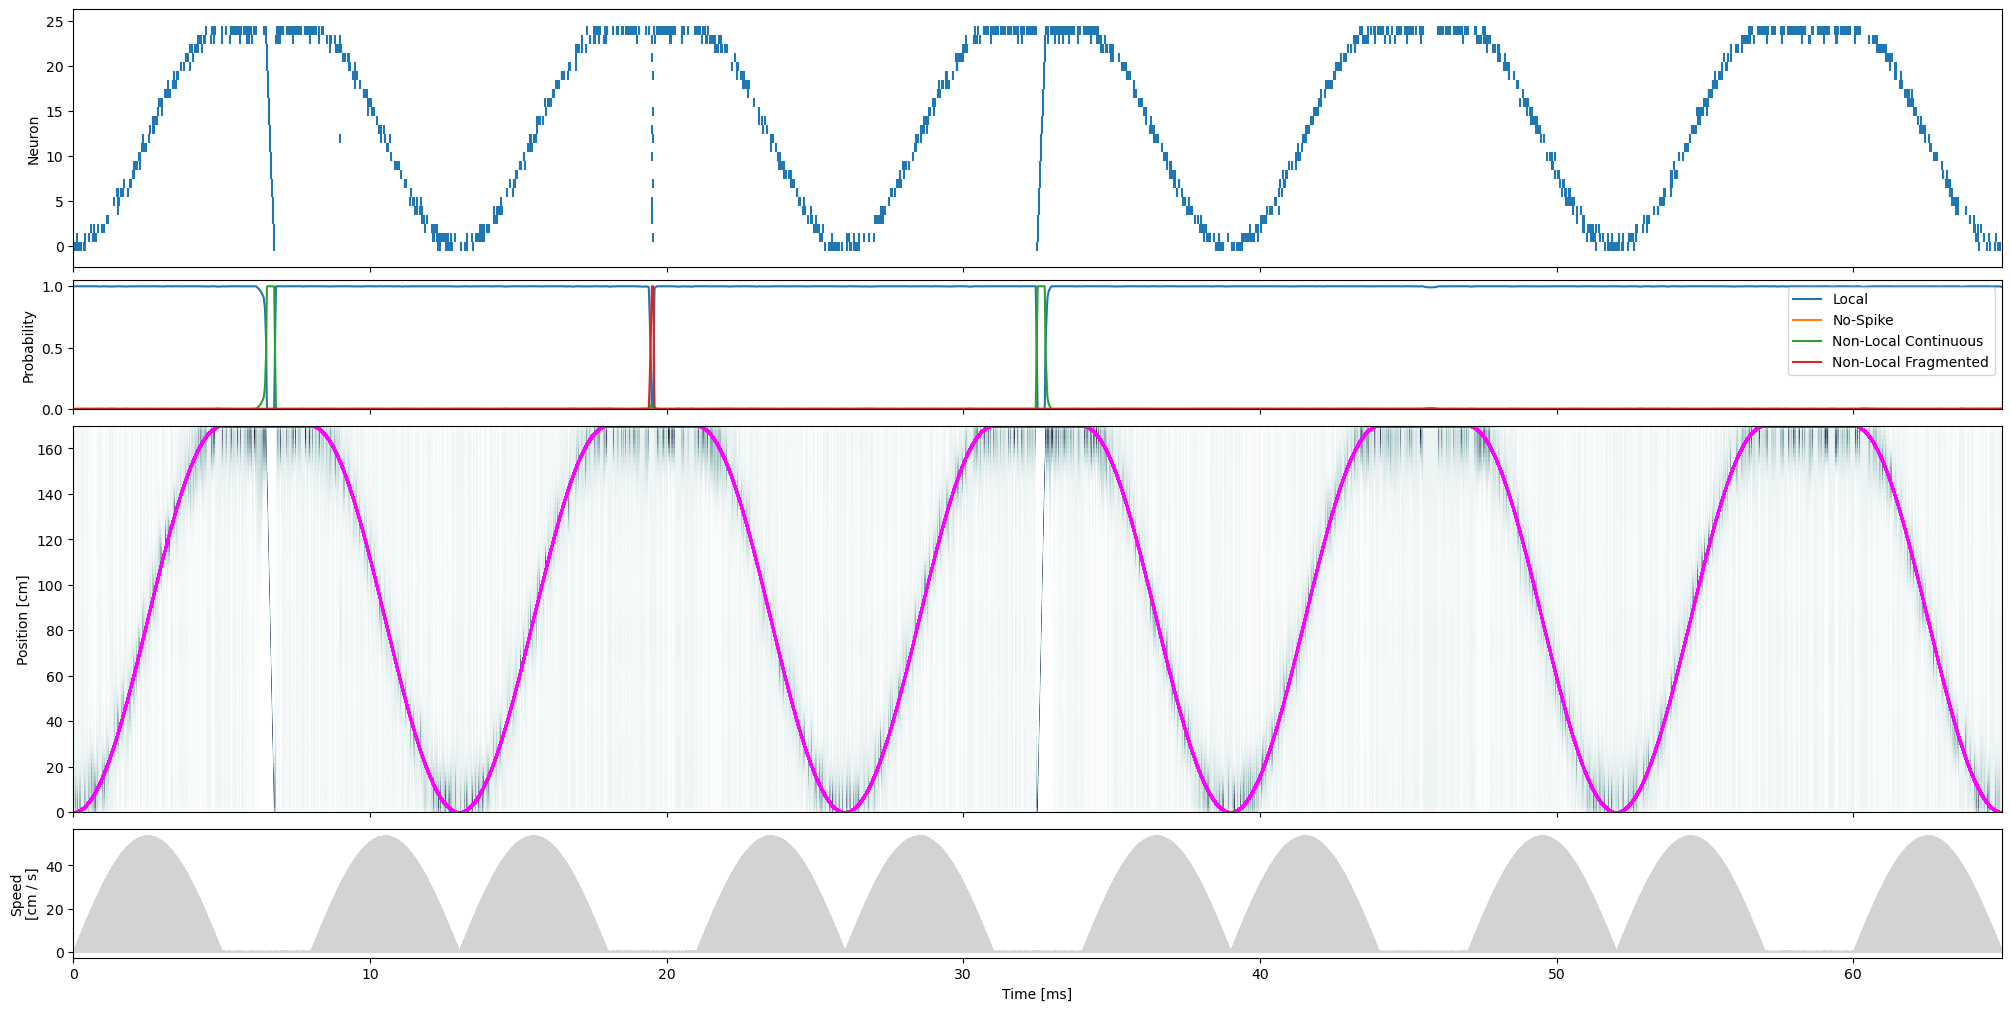

In [6]:
from non_local_detector.visualization import plot_non_local_model

plot_non_local_model(
    time,
    position,
    spike_times,
    speed,
    detector,
    result,
    figsize=(20, 10),
)

array([1.        , 0.9999852 , 0.99997103, ..., 0.994889  , 0.99483806,
       0.99478674], dtype=float32)